# Bayesian Forecaster

#### Imports

In [71]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import pickle

#### data setup

In [72]:
# importing data
experiment_type = "verysmall"
data_directory = '../data/experiment_' + experiment_type + '/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (2,1, 0))

#reshaping and trimming to exclude the last year
data = data.reshape(len(data),2*len(data[0]))
data_future = data[-365:,:]
data = data[:-365,:]
diffs = np.diff(data, axis=0)
T,D = diffs.shape

# creating the dataframe
hospital_list = np.loadtxt(data_directory + 'network_params/hospitals.txt', dtype=str, delimiter='\n')
df_cols = np.array([[h + ' supply',h + ' demand'] for h in hospital_list]).reshape(D)
df = pd.DataFrame(diffs, columns=df_cols)

df

,Orange County supply,Orange County demand,Oakland supply,Oakland demand
0,0.631582,-0.877368,0.097019,-0.122130
1,1.741602,3.733479,0.267541,0.519669
2,4.569952,5.611188,0.702018,0.781017
3,3.248084,1.434755,0.498933,0.199722
4,0.920804,0.176321,0.141446,0.024533
...,...,...,...,...
2430,-6.829226,-1.746880,-1.049062,-0.243154
2431,0.061868,-0.537839,0.009503,-0.074859
2432,-1.156395,-4.148470,-0.177636,-0.577435
2433,-0.541819,-4.171408,-0.083234,-0.580625


#### constructing the BVAR model

In [73]:
def ar_update(beta,n,h,df):
    df_values = df.values[h:]
    update = [
        pm.math.sum([
            pm.math.sum(beta[i,j] * df.values[h-(j+1):-(j+1)],axis=-1)
            for j in range(h)
        ],axis=0)
    for i in range(n)]
    return pm.math.stack(update, axis=-1)

def bvar_model(h,df,priors,draws=2000,tune=1000,chains=4,cores=4,max_treedepth=10):
    coords = {
        "lags": np.arange(h)+1,
        "vars": df.columns.tolist(),
        "eqs": df.columns.tolist(),
        "time": [t for t in df.index[h:]]
    }

    with pm.Model(coords=coords) as model:
        beta = pm.Normal(
            "beta",
            mu=priors["beta"]["mu"],
            sigma=priors["beta"]["sigma"],
            dims=("eqs","lags","vars")
        )
        alpha = pm.Normal(
            "alpha",
            mu=priors["alpha"]["mu"],
            sigma=priors["alpha"]["sigma"],
            dims=("eqs",)
        )
        data_obs = pm.Data(
            "data_obs",
            df.values[h:], 
            dims=("time","eqs"),
            mutable=True
        )

        n = df.shape[1]
        betaX = ar_update(beta,n,h,df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=("time",)
        )
        mu = alpha + betaX
        sigma = pm.HalfNormal(
            "noise",
            sigma=priors["noise"]["sigma"],
            dims=["vars"]
        )
        obs = pm.Normal(
            "obs",
            mu=mu,
            sigma=sigma,
            observed=data_obs,
            dims=["time","eqs"]
            )
        trace = pm.sample(
            draws=2000,
            tune=1000,
            chains=4,
            cores=4,
            random_seed=42,
            target_accept=0.95,
            nuts_sampler_kwargs={"max_treedepth": 10},
        )
    return model,trace

In [74]:
h = 3

priors = {
    "beta": {"mu": 0.0, "sigma": 10.0},
    "alpha": {"mu": 0.0, "sigma": 10.0},
    "noise": {"sigma": 10.0}
}

model, trace = bvar_model(h, df, priors)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, noise]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2582 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


#### looking at the model

In [75]:
az.summary(trace, var_names=["alpha", "beta","noise"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Orange County supply],0.049,0.068,-0.078,0.178,0.004,0.003,350.0,783.0,1.01
alpha[Orange County demand],0.020,0.075,-0.109,0.166,0.004,0.003,312.0,737.0,1.01
alpha[Oakland supply],0.007,0.011,-0.013,0.027,0.001,0.000,261.0,571.0,1.01
alpha[Oakland demand],0.003,0.011,-0.017,0.022,0.001,0.000,339.0,692.0,1.01
"beta[Orange County supply, 1, Orange County supply]",0.073,1.601,-3.118,3.000,0.144,0.102,127.0,213.0,1.02
"beta[Orange County supply, 1, Orange County demand]",0.438,1.389,-2.262,2.684,0.148,0.105,90.0,246.0,1.03
"beta[Orange County supply, 1, Oakland supply]",0.203,10.420,-18.772,21.031,0.940,0.666,127.0,208.0,1.02
"beta[Orange County supply, 1, Oakland demand]",-3.349,9.975,-19.462,16.037,1.061,0.753,90.0,246.0,1.03
"beta[Orange County supply, 2, Orange County supply]",-0.046,1.360,-2.542,2.757,0.151,0.107,79.0,245.0,1.04
"beta[Orange County supply, 2, Orange County demand]",-0.212,1.361,-2.723,2.402,0.198,0.141,48.0,150.0,1.07


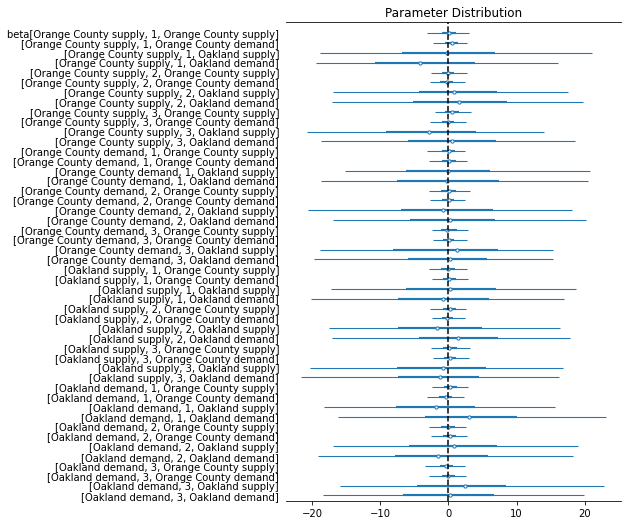

In [78]:
#fig, ax = plt.subplots(figsize=(20, 100))
az.plot_forest(trace, var_names=["beta"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Parameter Distribution");

/opt/miniconda3/lib/python3.8/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_posterior, generating only 40 plots
  warnings.warn(


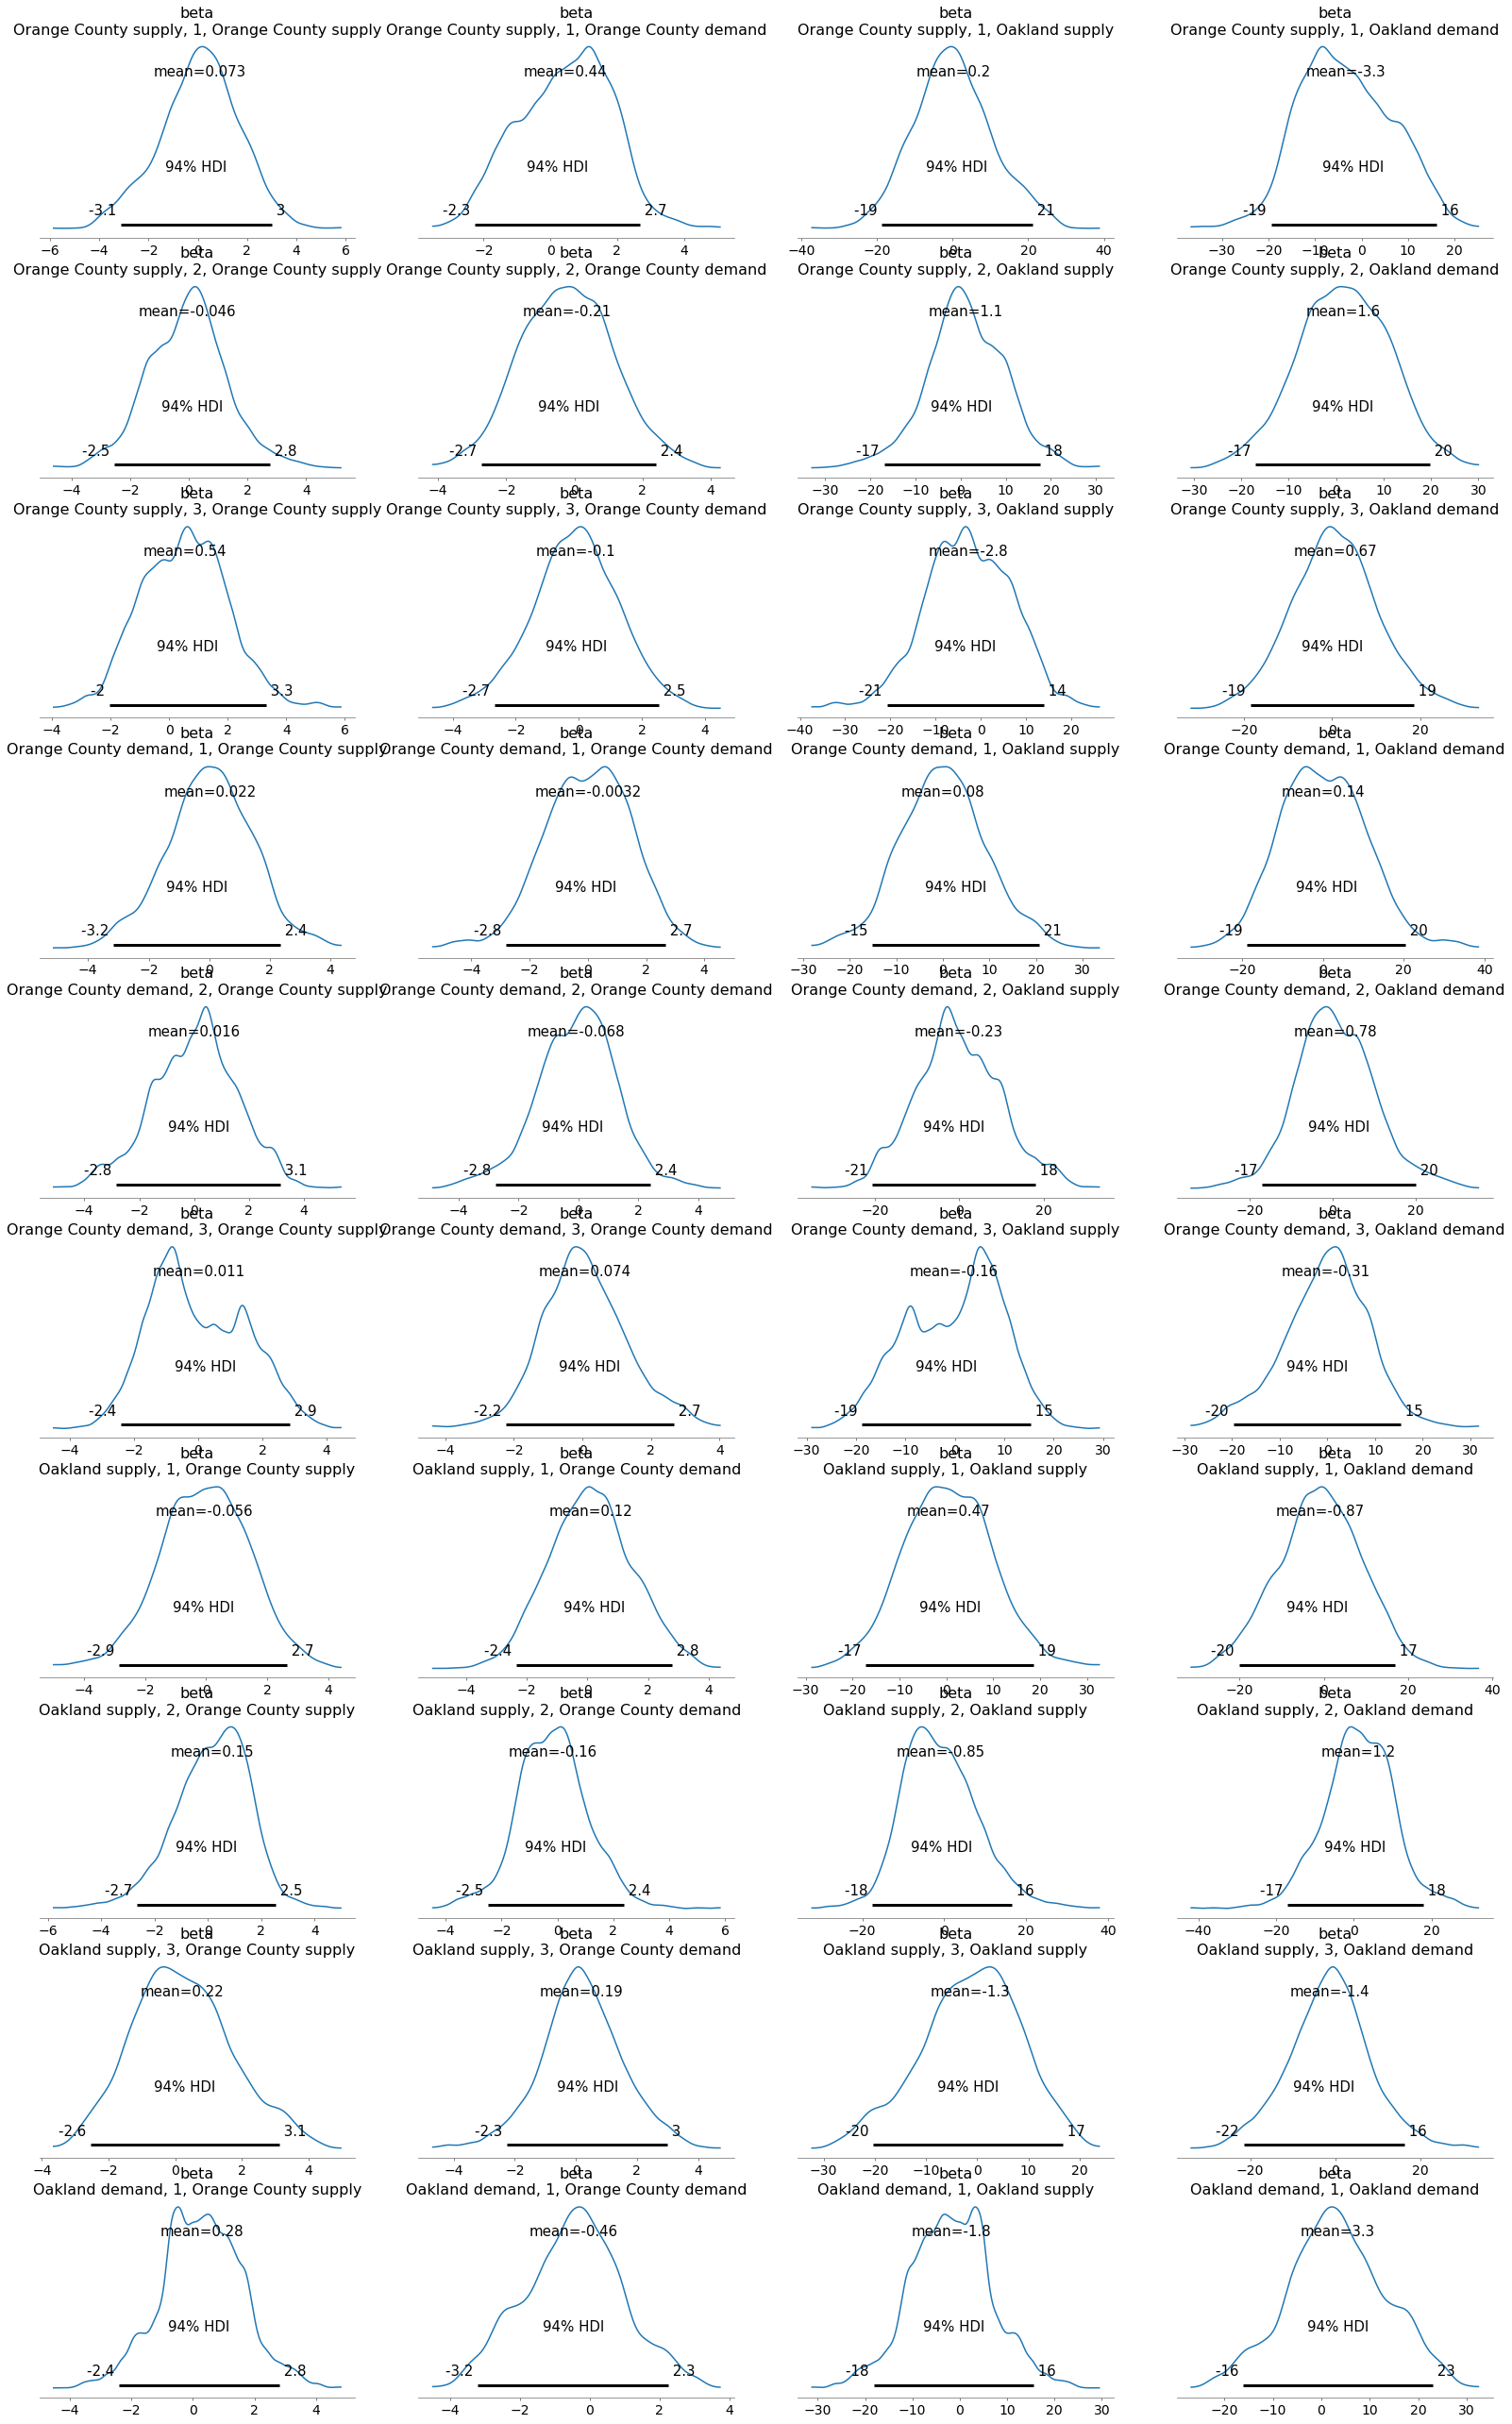

In [79]:
az.plot_posterior(trace, var_names=["beta"]);

#### forecasting

In [64]:
def predict_future(f, trace, h):
    beta_samples = trace.posterior["beta"].values  # Shape: (chains, samples, eqs, lags,variables)
    alpha_samples = trace.posterior["alpha"].values  # Shape: (chains,samples,eqs)
    sigma_samples = trace.posterior["noise"].values  # Shape: (chains,samples,eqs)

    
    return forecasts

In [70]:
f=3
trace.posterior["beta"].values.shape
#future_predictions = predict_future(f,trace,h)
#future_predictions.shape

(4, 2000, 4, 3, 4)